In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import ast   


# Load merged dataset created in Week 4
import pandas as pd

import pandas as pd

merged = pd.read_csv(r"C:\Users\shery\Xing-Sheryl-old\IS 477 Project\ratings_with_metadata.csv")




In [9]:
merged.head(), merged.columns, merged.shape


(   userId  movieId  rating   timestamp      rating_datetime             title  \
 0       1        1     4.0   964982703  2000-07-30 18:45:03  Toy Story (1995)   
 1       5        1     4.0   847434962  1996-11-08 06:36:02  Toy Story (1995)   
 2       7        1     4.5  1106635946  2005-01-25 06:52:26  Toy Story (1995)   
 3      15        1     2.5  1510577970  2017-11-13 12:59:30  Toy Story (1995)   
 4      17        1     4.5  1305696483  2011-05-18 05:28:03  Toy Story (1995)   
 
    release_year                                       genres  \
 0        1995.0  Adventure|Animation|Children|Comedy|Fantasy   
 1        1995.0  Adventure|Animation|Children|Comedy|Fantasy   
 2        1995.0  Adventure|Animation|Children|Comedy|Fantasy   
 3        1995.0  Adventure|Animation|Children|Comedy|Fantasy   
 4        1995.0  Adventure|Animation|Children|Comedy|Fantasy   
 
                                          genres_list  
 0  ['Adventure', 'Animation', 'Children', 'Comedy...  
 1

This cell lets us confirm that the merged dataset loaded correctly and shows us the available columns. Seeing the column names and a few sample rows helps us decide which fields to use for recommendations, such as title, genres, release_year, and rating.

In [19]:
import ast 

merged['genres_list'] = merged['genres_list'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

genre_data = merged.explode('genres_list')

genre_data['genres_list'] = genre_data['genres_list'].astype(str).str.strip()

movie_ratings_by_genre = (
    genre_data
    .groupby(['movieId', 'title', 'genres_list'])['rating']
    .mean()
    .reset_index()
)

def recommend_by_genre(genre, n=10, min_ratings=20):
    """
    Return the top n movies for a given genre,
    filtered to movies with at least min_ratings ratings.
    """
    sub = genre_data[genre_data['genres_list'] == genre]

    counts = sub.groupby('movieId')['rating'].count()
    valid_ids = counts[counts >= min_ratings].index

    recs = movie_ratings_by_genre[
        (movie_ratings_by_genre['genres_list'] == genre) &
        (movie_ratings_by_genre['movieId'].isin(valid_ids))
    ]

    return recs.sort_values('rating', ascending=False).head(n)

recommend_by_genre('Drama', n=10)


,movieId,title,genres_list,rating
1862,1104,"Streetcar Named Desire, A (1951)",Drama,4.475000
594,318,"Shawshank Redemption, The (1994)",Drama,4.429022
1543,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama,4.333333
1480,898,"Philadelphia Story, The (1940)",Drama,4.310345
880,475,In the Name of the Father (1993),Drama,4.300000
1981,1204,Lawrence of Arabia (1962),Drama,4.300000
1425,858,"Godfather, The (1972)",Drama,4.289062
2057,1235,Harold and Maude (1971),Drama,4.288462
4916,2959,Fight Club (1999),Drama,4.272936
2168,1276,Cool Hand Luke (1967),Drama,4.271930


This code first converts the genres_list column from string representations into actual Python lists, then “explodes” the dataset so each genre appears in its own row. After that, it calculates the average rating for every movie within each genre and stores the results in a summary table. Finally, it defines a helper function that returns top-rated movies for a chosen genre, filtering out films with too few ratings so the recommendations are more reliable.

In [20]:
merged['release_year'] = (
    merged['title'].str.extract(r'\((\d{4})\)').astype(float)
)

movie_avg = (
    merged.groupby(['movieId', 'title', 'release_year'])['rating']
    .mean()
    .reset_index()
)

def recommend_by_year(year, n=10, min_ratings=20):
    sub = merged[merged['release_year'] == year]
    counts = sub.groupby('movieId')['rating'].count()
    valid_ids = counts[counts >= min_ratings].index

    recs = movie_avg[
        (movie_avg['release_year'] == year) &
        (movie_avg['movieId'].isin(valid_ids))
    ]
    
    return recs.sort_values('rating', ascending=False).head(n)

recommend_by_year(1995)


,movieId,title,release_year,rating
46,50,"Usual Suspects, The (1995)",1995.0,4.237745
596,741,Ghost in the Shell (Kôkaku kidôtai) (1995),1995.0,4.148148
183,215,Before Sunrise (1995),1995.0,4.041667
97,110,Braveheart (1995),1995.0,4.031646
28,29,"City of Lost Children, The (Cité des enfants p...",1995.0,4.013158
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),1995.0,3.983051
43,47,Seven (a.k.a. Se7en) (1995),1995.0,3.975369
147,175,Kids (1995),1995.0,3.975000
5,6,Heat (1995),1995.0,3.946078
15,16,Casino (1995),1995.0,3.926829


This code extracts the movie’s release year from the title by identifying the four-digit year in parentheses and storing it in a new release_year column. It then computes each movie’s average rating using a grouped summary table that includes the movie ID, title, and release year. The recommend_by_year function filters movies released in a chosen year, keeps only those with a minimum number of ratings, and returns the highest-rated films from that year. Running recommend_by_year(1995) produces a ranked list of the top movies released in 1995 based on user ratings.

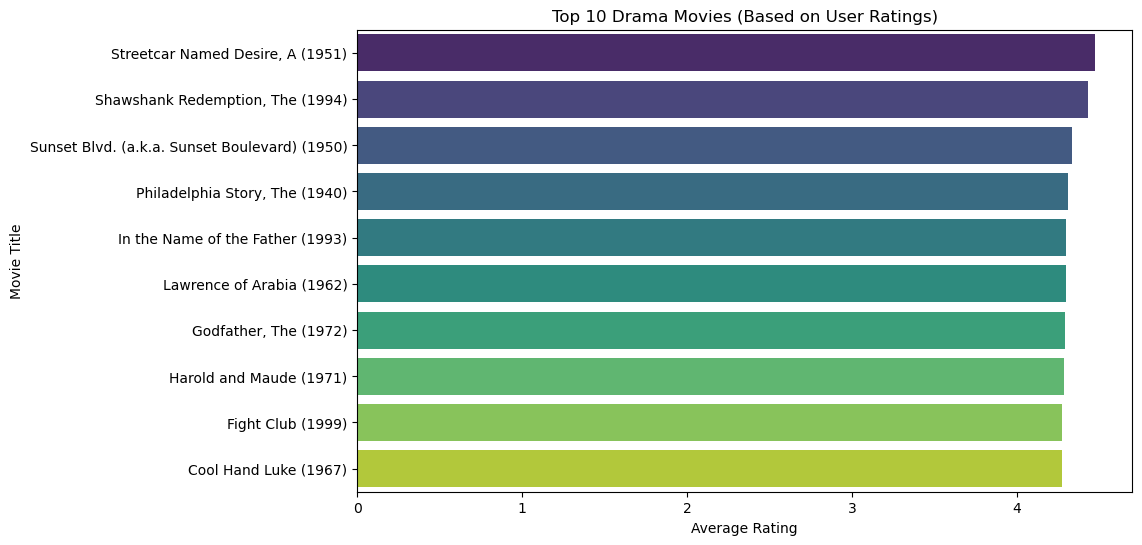

In [21]:
top_drama = recommend_by_genre('Drama', n=10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_drama, x='rating', y='title', palette='viridis')
plt.title("Top 10 Drama Movies (Based on User Ratings)")
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.show()


This visualization plots the top recommended movies for a chosen category as a horizontal bar chart, making it easy to compare their average ratings at a glance. By listing movie titles on the y-axis and ratings on the x-axis, the chart clearly highlights which films outperform others within the selected group. Overall, the plot provides a simple and intuitive way to interpret the recommender’s output and communicate key insights.